# Movie Script automatic reader

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import scipy as sp
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression


import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from textblob import TextBlob, Word

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

In [16]:
import os
import sys
os.environ['SPARK_HOME'] = "C:\Users\Pedro\Downloads\spark-2.0.2-bin-hadoop2.7\spark-2.0.2-bin-hadoop2.7"
sys.path.append("C:\Users\Pedro\Downloads\spark-2.0.2-bin-hadoop2.7\spark-2.0.2-bin-hadoop2.7\python")
sys.path.append("C:\Users\Pedro\Downloads\spark-2.0.2-bin-hadoop2.7\spark-2.0.2-bin-hadoop2.7\python\lib\py4j-0.8.2.1-src.zip")

#from spark_sklearn import GridSearchCV

In [2]:
movie_ratings = pd.read_pickle('movie_ratings.pkl')

In [3]:
movie_ratings['Runtime'] = movie_ratings.Runtime.apply(lambda x: int(x.replace('min','')) )

In [4]:
class SentimentMetrics(TransformerMixin):
    def changes (self, sentiments):
        N_changes = 0
        for i in range(len(sentiments)-1):
            if sentiments[i]*sentiments[i+1] < 0:
                N_changes+=1
        return N_changes     
    
    def sentiment(self, script, pages = 100, ma = 5):
        #Creates a moving average of the sentiment polarity of the script pages (or %)
        sentiment = []
        for i in range(pages+1-ma):
            sentiment.append(TextBlob(script[i*len(script)/pages:(i+ma)*len(script)/pages]).sentiment.polarity)
        return sentiment    
        
    def transform(self, X, **transform_params):  
        S = X.apply(lambda x: SentimentMetrics.sentiment(self, x))
        sentiment_dic = {
       'Range': S.apply(lambda x: max(x) - min(x)),
       #'Sentiment_avg': S.apply(lambda x: x.mean()),
       #'Sentiment_std': S.apply(lambda x: x.std()),
       'Max_sentiment': S.apply(lambda x: max(x)),
       'Max_sentiment_loc': S.apply(lambda x: x.index(max(x))),
       'Min_sentiment': S.apply(lambda x: min(x)),
       'Min_sentiment_loc': S.apply(lambda x: x.index(min(x))),
       'Max_pos_change': S.apply(lambda x: pd.Series(x).diff(1).max()),
       'Max_pos_loc': S.apply(lambda x: list(pd.Series(x).diff(1)).index(pd.Series(x).diff(1).max())),
       'Max_neg_change': S.apply(lambda x: pd.Series(x).diff(1).min()),
       'Max_neg_loc': S.apply(lambda x: list(pd.Series(x).diff(1)).index(pd.Series(x).diff(1).min())),
       'Begin_sentiment': S.apply(lambda x: x[0]),
       'End_sentiment': S.apply(lambda x: x[-1]),
       'Total_change': S.apply(lambda x: x[-1] - x[0]),
       'plot_twist_index': S.apply(lambda x: (max(x[-10:]) - min(x[-10:]))/(max(x[:-10]) - min(x[:-10]) + 0.01)),
       'pol_changes': S.apply(lambda x: SentimentMetrics.changes(self, x))
        }
            
        return sp.sparse.csr_matrix(pd.DataFrame(sentiment_dic).astype(float))
    
        
    
    def fit(self, X, y=None, **fit_params):
        return self      

class NamedEntities(TransformerMixin):        
    def number_entities(self, text):
        upper = [i for i in TextBlob(text).words if (i.isupper() and i.lower() not in stopwords.words('english'))]
        tagged = pos_tag(upper)
        return len(set([word for word,pos in tagged if pos == 'NNP']))
    
    def transform (self, X):
        return pd.DataFrame(X.apply(lambda x: NamedEntities.number_entities(self,x)))
    
    def fit(self, X, y=None, **fit_params):
        return self      
        
class ToSparse(TransformerMixin):        
    def transform (self, X):
        return sp.sparse.csr_matrix(X).T
        
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)    
    
    def fit(self, X, y=None, **fit_params):
        return self     

class SelectColumn(TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def transform(self, X, **transform_params):
        return X[self.column]
    
    def fit(self, X, y=None, **fit_params):
        return self      

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
def word_tokenize(text, how='lemma'):
    words = TextBlob(text).words
    if how == 'lemma':
        return [word.lemmatize() for word in words]
    elif how == 'stem':
        return [stemmer.stem(word) for word in words]
    
def sentence_tokenize(text):
    words = TextBlob(text.replace(',', '.')).sentences
    return [word for word in words]
   
from sklearn import decomposition

from sklearn.base import BaseEstimator
class DenseTransformer(TransformerMixin, BaseEstimator):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [5]:
pipe_genre = Pipeline([('select_genre', SelectColumn('Genre')),
                       ('vect', CountVectorizer())])

pipe_runtime = Pipeline([('select_runtime', SelectColumn('Runtime')),('sparse', ToSparse())])

pipe_script = Pipeline([('select_script', SelectColumn('script')),
                       ('union', FeatureUnion([('sentiment', SentimentMetrics()), 
                                               ('named', NamedEntities())]))])

features = FeatureUnion([('script', pipe_script), ('genre', pipe_genre), ('runtime', pipe_runtime)])
preprocess = Pipeline([('dense', DenseTransformer()),
                       ('zscore', StandardScaler())])

In [60]:
X = features.fit_transform(movie_ratings)

In [6]:
y = movie_ratings.imdbRating    

In [7]:
##DELETE AFTER##
import cPickle as pickle
with open('test_sparse_array.dat', 'rb') as infile:
    X = pickle.load(infile)
y = movie_ratings.imdbRating    

### Random Forest

In [15]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()

pipe = Pipeline([('preprocess', preprocess) ,('forest', rfreg)])

param_grid = dict(forest__max_depth = range(1,21), forest__max_features = X.shape[1] +1, forest__n_estimators = range(10,140,20))
grid = GridSearchCV(pipe, param_grid, scoring='mean_absolute_error', n_jobs=1, error_score = 0)
grid.fit(X, y)


print grid.best_score_
#-0.653416058959
print grid.best_params_
#{'forest__max_features': 24, 'forest__n_estimators': 50, 'forest__max_depth': 14}


-0.682396416705
{'forest__max_features': 2, 'forest__n_estimators': 30, 'forest__max_depth': 3}


## Decision Tree

In [64]:
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor()

pipe_tree = Pipeline([('preprocess', preprocess), ('tree', treereg)])

param_grid = {'tree__max_depth': range(1,21), 'tree__max_features': range(1, X.shape[1] +1), 'tree__min_samples_leaf': range(1,6)}
grid = GridSearchCV(pipe_tree, param_grid, scoring='mean_absolute_error')
grid.fit(X, y)
print grid.best_score_
#-0.672306883255
print grid.best_params_
#{'tree__max_depth': 2, 'tree__max_features': 11, 'tree__min_samples_leaf': 3}

-0.672306883255
{'tree__max_depth': 2, 'tree__max_features': 11, 'tree__min_samples_leaf': 3}


## SGD Regressor

In [65]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor()

pipe_sgd = Pipeline([('preprocess', preprocess), ('sgd', sgd)])

parameters = {'sgd__loss':('squared_loss', 'huber', 'epsilon_insensitive',  'squared_epsilon_insensitive'), 
              'sgd__penalty':('none', 'l2', 'l1', 'elasticnet'),
              'sgd__alpha': (1e-4,1e-3,1e-2,1e-1,1,1e1),
              'sgd__n_iter': (100, 1000, 10000)
             }
clf = GridSearchCV(pipe_sgd, parameters, scoring='mean_absolute_error')
clf.fit(X,movie_ratings.imdbRating)

print clf.best_params_
#{'sgd__n_iter': 10000, 'sgd__penalty': 'elasticnet', 'sgd__loss': 'squared_loss', 'sgd__alpha': 0.1}
print clf.best_score_
#-0.652633288235

{'sgd__n_iter': 10000, 'sgd__penalty': 'elasticnet', 'sgd__loss': 'squared_loss', 'sgd__alpha': 0.1}
-0.652633288235


## Essemble Regressor

In [29]:
class EnsembleRegressor(BaseEstimator, ClassifierMixin):
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)

    def predict(self, X):
        self.pred_ = np.asarray([model.predict(X) for model in self.models])
        if self.weights:
            avg = np.average(self.pred_, axis=0, weights=self.weights)
        else:
            avg = np.average(self.pred_, axis=0)
        return avg

In [30]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor(max_features= 14, n_estimators= 50, max_depth= 24)
treereg = DecisionTreeRegressor(max_depth= 2, max_features= 11, min_samples_leaf= 3)
sgd = SGDRegressor(n_iter= 10000, penalty= 'elasticnet', loss= 'squared_loss', alpha= 0.1)

models = [rfreg, treereg, sgd]
reg = EnsembleRegressor(models)

pipe_reg = Pipeline([('preprocess', preprocess), ('reg', reg)])

params = {'reg__weights': [[1,1,1],[2,1,1],[1,2,1],[1,1,2],[1,0,1]]}
grid = GridSearchCV(pipe_reg, params, cv=5, scoring='mean_absolute_error')
grid.fit(X,movie_ratings.imdbRating)

print grid.best_params_
#{'reg__weights': [1, 0, 1]}
print grid.best_score_
#-0.648697631076

{'reg__weights': [1, 0, 1]}
-0.648697631076


## Some metrics

In [31]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor



models = [rfreg, treereg, sgd]


Xtrain, Xtest, ytrain, ytest = train_test_split(X,y)
reg = EnsembleRegressor(models, [1,0,1])
pipe_reg = Pipeline([('preprocess', preprocess), ('reg', reg)])

In [32]:
pipe_reg.fit(Xtrain,ytrain)
ypred = pipe_reg.predict(Xtest)

In [33]:
Results = pd.DataFrame({'Actual': np.array(ytest), 'Predicted': ypred}, index=range(len(ytest)))
Results['RMSE'] = np.abs(Results.Actual - Results.Predicted)

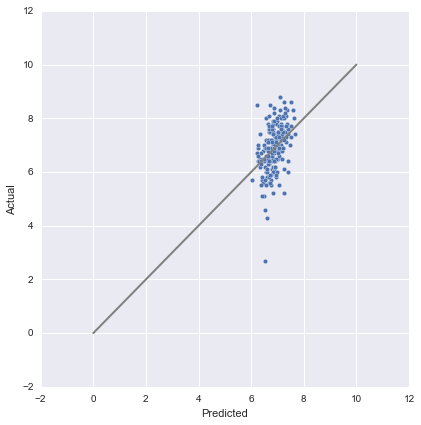

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


pair = sns.pairplot(Results, x_vars=['Predicted'],y_vars = 'Actual', size=6)

plt.plot([0, 10], [0, 10], linewidth=2, c = '0.5')

In [38]:
ranking = []
dif = []
for i in range(len(Results)-1):
    for j in range(len(Results)-1):
        if j>i:
            ranking.append((Results.Predicted[i]-Results.Predicted[j])*(Results.Actual[i] - Results.Actual[j])>=0)
            dif.append(np.abs(np.abs((Results.Actual[i] - Results.Actual[j]))))
error = pd.DataFrame(ranking, columns = ['Correct Ranking'])
error['Actual difference'] = dif
   

In [40]:
error.groupby('Correct Ranking').describe()

Actual difference
Correct Ranking                         
False           count        5796.000000
                mean            0.796808
                std             0.633223
                min             0.100000
                25%             0.300000
                50%             0.600000
                75%             1.100000
                max             5.800000
True            count       12159.000000
                mean            1.061494
                std             0.829862
                min             0.000000
                25%             0.400000
                50%             0.900000
                75%             1.500000
                max             6.100000

In [75]:
float(len(error[(error.ranking == False) & (error.error > 1)]))/len(error)

0.12219437482595377

In [76]:
error.ranking.value_counts()

True     11870
False     6085
Name: ranking, dtype: int64

## Clustering

In [7]:
from sklearn.preprocessing import Normalizer
pipe_genre = Pipeline([('select_genre', SelectColumn('Genre')),
                       ('vect', CountVectorizer())])

pipe_runtime = Pipeline([('select_runtime', SelectColumn('Runtime')),('sparse', ToSparse())])

pipe_script = Pipeline([('select_script', SelectColumn('script')),
                       ('union', FeatureUnion([('sentiment', SentimentMetrics()), 
                                               ('named', NamedEntities()),
                                              ('tfidf', TfidfVectorizer(analyzer= lambda x: word_tokenize(x, how='lemma'), ngram_range=(1,2), stop_words='english',max_df=600))]))])

features = FeatureUnion([('script', pipe_script), ('genre', pipe_genre), ('runtime', pipe_runtime)])
preprocess = Pipeline([('dense', DenseTransformer()),
                       ('nrm', Normalizer())])


comp_pipe = Pipeline([('feat', features), ('pre', preprocess)])
X_comps = comp_pipe.fit_transform(movie_ratings)

In [110]:
from sklearn.neighbors import KDTree

kdt = KDTree(X_comps)

def comps(kdt,x, r=3):
    comps = kdt.query_radius(x, r) 
    return [movie_ratings.title[i] for i in comps[0][0:3]]

In [106]:
comps(kdt,np.matrix(X_comps[6,:]),r=0.05)

[6]


[u'17 Again']

In [116]:
comp = []
for i in range(movie_ratings.shape[0]):
    temp = comps(kdt,np.matrix(X_comps[i,:]),r=0.05)
    s = ''
    for i in temp:
        s += str(i) + ' ,'
    comp.append(s)

In [117]:
movie_ratings['comps'] = pd.Series(comp)

In [121]:
movie_ratings[['title', 'comps']]

,title,comps
0,10 Things I Hate About You,"10 Things I Hate About You ,"
1,12 and Holding,"American Splendor ,12 and Holding ,"
2,12 Years a Slave,"Midnight Express ,Orphan ,Metro ,"
3,127 Hours,"127 Hours ,"
4,1492: Conquest of Paradise,"1492: Conquest of Paradise ,"
5,15 Minutes,"Se7en ,Black Swan ,15 Minutes ,"
6,17 Again,"17 Again ,"
7,187,"187 ,"
8,2001: A Space Odyssey,"Fright Night ,Star Wars: The Force Awakens ,Da..."
9,2012,"2012 ,"
